In [55]:
# imports
import random
import numpy as np
import torch as tr
import matplotlib.pyplot as pt
from time import perf_counter

In [56]:
"""
Simplified toy version of stack grammar
"""

num_rules = 26
alphabet = "".join(chr(n) for n in range(ord("A"), ord("A")+num_rules))
print(alphabet)

max_hyps = 4
rules = {0: []}
for n in range(1, len(alphabet)):
  consequent = n
  num_hyps = random.randrange(1, min(max_hyps, n)+1)
  hyps = random.sample(range(n), num_hyps)
  rules[consequent] = hyps

for consequent, hypotheses in rules.items():
  print(f"{alphabet[consequent]} <- {''.join([alphabet[h] for h in hypotheses])}")


ABCDEFGHIJKLMNOPQRSTUVWXYZ
A <- 
B <- A
C <- A
D <- A
E <- CAD
F <- BCAE
G <- C
H <- ACGF
I <- EDBC
J <- HADE
K <- B
L <- F
M <- B
N <- CJK
O <- I
P <- HKI
Q <- FHCM
R <- E
S <- OGI
T <- K
U <- A
V <- I
W <- Q
X <- HSFE
Y <- H
Z <- H


In [57]:
"""
Generate toy proof stack traces
"""
# print(random.randrange())
def random_stack_trace():
  goal = random.randrange(1, len(alphabet)) # skip trivial goal
  stack = [goal]
  stacks = [stack]
  while len(stack) > 0:
    stack, top = stack[:-1], stack[-1]
    stack = stack + rules[top]
    stacks.insert(0, stack)
  return stacks


stacks = random_stack_trace()
for stack in stacks:
  print([alphabet[s] for s in stack])


[]
['A']
['C']
['C', 'A']
['C', 'A', 'A']
['C', 'A', 'D']
['E']
['E', 'A']
['E', 'D']
['E', 'D', 'A']
['E', 'D', 'B']
['E', 'D', 'B', 'A']
['E', 'D', 'B', 'C']
['I']
['O']
['O', 'A']
['O', 'C']
['O', 'G']
['O', 'G', 'A']
['O', 'G', 'C']
['O', 'G', 'C', 'A']
['O', 'G', 'C', 'A', 'A']
['O', 'G', 'C', 'A', 'D']
['O', 'G', 'E']
['O', 'G', 'E', 'A']
['O', 'G', 'E', 'D']
['O', 'G', 'E', 'D', 'A']
['O', 'G', 'E', 'D', 'B']
['O', 'G', 'E', 'D', 'B', 'A']
['O', 'G', 'E', 'D', 'B', 'C']
['O', 'G', 'I']
['S']


torch.Size([13, 15])
torch.Size([13, 15])
torch.Size([13, 15, 64])
[]
['A']
['B']
['B', 'A']
['B', 'C']
['B', 'C', 'A']
['B', 'C', 'A', 'A']
['B', 'C', 'A', 'C']
['B', 'C', 'A', 'C', 'A']
['B', 'C', 'A', 'C', 'A', 'A']
['B', 'C', 'A', 'C', 'A', 'D']
['B', 'C', 'A', 'E']
['F']


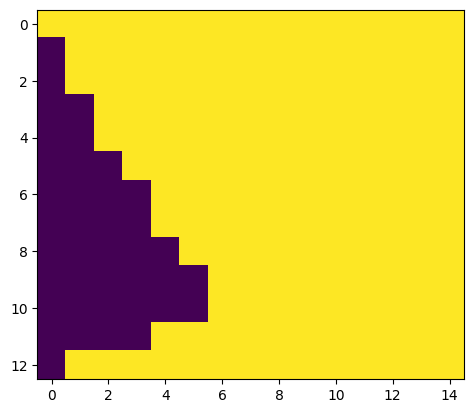

In [58]:
PAD_IDX = len(alphabet)
emb_dim = 64
embedding = tr.nn.Embedding(num_embeddings=len(alphabet)+1, embedding_dim=emb_dim, padding_idx=PAD_IDX)
"""
Pad multiple stack states in the trace to constant length
Returns padded embeddings as well as padding mask
TODO: debug the NaNs?
"""
def pad_trace(stacks):
  max_len = 15
  padded = tr.full((len(stacks), max_len), PAD_IDX)
  pad_mask = tr.full(padded.shape, True)
  for s, stack in enumerate(stacks):
    padded[s,:len(stack)] = tr.tensor(stack).to(tr.float32)
    pad_mask[s,:len(stack)] = False
  return padded, pad_mask

stacks = random_stack_trace()
padded, mask = pad_trace(stacks)
print(padded.shape)
print(mask.shape)
print(embedding(padded).shape)
for stack in stacks: print([alphabet[s] for s in stack])
_ = pt.imshow(mask)


In [59]:
Embeddings = tr.nn.Embedding(num_embeddings=27,embedding_dim=27).to(tr.float32)
print(Embeddings(tr.tensor(0)))

tensor([-1.6984, -0.4892, -0.7856,  1.8762,  2.3947, -0.8159, -0.8512, -2.0546,
         0.2886,  0.2558, -1.1288, -0.4845, -0.4442, -1.7529,  0.2610,  0.3653,
         1.7927,  1.9961, -1.9478, -0.1336, -0.0489, -0.5422,  0.3088,  0.8519,
        -0.5864,  0.3914,  0.6768], grad_fn=<EmbeddingBackward0>)


In [76]:
loss_fn = tr.nn.CrossEntropyLoss()
d_model = 27
embedding = tr.nn.Embedding(num_embeddings=len(alphabet)+1, embedding_dim=d_model, padding_idx=PAD_IDX)
decoder = tr.nn.Sequential(
    tr.nn.Conv1d(1,12,3), # input channels, output channels, kernel size
    tr.nn.Tanh(),
    tr.nn.Flatten(0,2),
    tr.nn.Linear(9000,27),
)
opt = tr.optim.Adam(list(decoder.parameters()) + list(embedding.parameters()), lr=0.08)

pred = []
loss_curve = []
def train(stacks,target):
    # model(input) returns output

    # standard torch dataloader and optimizer

    # use the model in training mode
    decoder.train()

    # loop over every batch in the dataset
    padded, pad_mask = pad_trace(stacks)

    memory = embedding(padded)

    goal = embedding(padded[-1])
    goal = goal[:,None,:]

    for idx,stack in enumerate(memory):

      stack = stack[:,None,:]

      concat = [stack]
      concat.append(goal)
      concat = tr.stack(concat)

      #flatten to join the 2 embeddings
      flat = tr.nn.Flatten(0,1)

      concat = flat(concat)


      result = decoder(concat)

      # good old dot product similarity
      result = result*embedding.weight.sum(-1)


      # zero the gradient
      opt.zero_grad()

      # since our loss function needs values as float

      # print(result.shape,target.shape)
      
      # input to loss function
      loss = loss_fn(result, target[idx])

      # updating our loss graph
      loss_curve.append(loss.item())

      # differentiate
      loss.backward(retain_graph=True)

      # change parameters of the network in accordance with direction of diffrentiation
      opt.step()
      pred.append(result.argmax())
    return loss_curve



stacks = random_stack_trace()
for stack in stacks: print([alphabet[s] for s in stack])

targs = [s[-1] for s in stacks[1:]]
targs =  tr.tensor(targs)

losses = train(stacks[:-1],targs)
# print(logits)
# print(logits.shape)

[]
['A']
['C']
['C', 'A']
['C', 'A', 'A']
['C', 'A', 'C']
['C', 'A', 'C', 'A']
['C', 'A', 'C', 'C']
['C', 'A', 'C', 'G']
['C', 'A', 'C', 'G', 'A']
['C', 'A', 'C', 'G', 'B']
['C', 'A', 'C', 'G', 'B', 'A']
['C', 'A', 'C', 'G', 'B', 'C']
['C', 'A', 'C', 'G', 'B', 'C', 'A']
['C', 'A', 'C', 'G', 'B', 'C', 'A', 'A']
['C', 'A', 'C', 'G', 'B', 'C', 'A', 'C']
['C', 'A', 'C', 'G', 'B', 'C', 'A', 'C', 'A']
['C', 'A', 'C', 'G', 'B', 'C', 'A', 'C', 'A', 'A']
['C', 'A', 'C', 'G', 'B', 'C', 'A', 'C', 'A', 'D']
['C', 'A', 'C', 'G', 'B', 'C', 'A', 'E']
['C', 'A', 'C', 'G', 'F']
['C', 'H']
['C', 'H', 'A']
['C', 'H', 'A', 'A']
['C', 'H', 'A', 'D']
['C', 'H', 'A', 'D', 'A']
['C', 'H', 'A', 'D', 'C']
['C', 'H', 'A', 'D', 'C', 'A']
['C', 'H', 'A', 'D', 'C', 'A', 'A']
['C', 'H', 'A', 'D', 'C', 'A', 'D']
['C', 'H', 'A', 'D', 'E']
['C', 'J']
['C', 'J', 'A']
['C', 'J', 'B']
['C', 'J', 'K']
['N']


In [77]:
"""
Training loop
"""

num_updates = 5001


start = perf_counter()

accu_curve = []
loss_curve.clear()
init = embedding(tr.tensor(0))
for update in range(num_updates):


  pred.clear()

  # prepare training batch
  stacks = random_stack_trace()

  targs = [s[-1] for s in stacks[1:]] # target is rule pushed at next step
  stacks = stacks[:-1] # inputs are stacks up to last step

  # forward
  targs =  tr.tensor(targs)
  losses = train(stacks,targs)

  # opt.zero_grad()
  # loss = loss_fn(logits, targs)
  (loss_curve.append(loss) for loss in losses)
  # print(len(pred),len(targs))
  count = 0
  for i in range(len(pred)):
    # print(pred[i],targs[i],"here")
    if pred[i] == targs[i]:
      count += 1
  accu_curve.append(tr.tensor(count)/len(targs))

  # check if embeddings are updating
  # print(embedding(tr.tensor(0)))

  # progress
  if update % 100 == 0:
    # print("hi")
    print(f"update {update}: loss={loss_curve[-1]}, accu={accu_curve[-1]}")

    # check if embeddings are accumulating gradient
    # print(embedding.weight.grad)
    # print(embedding(tr.tensor(0)))
    # assert(tr.allclose(embedding(tr.tensor(0)),init))

    # character comparison
    for i in range(len(targs)):
      print(chr(ord('@')+pred[i].int()+1),chr(ord('@')+targs[i].int()+1))
      # print(pred[i],targs[i])

print(f"total time = {perf_counter()-start}s")

update 0: loss=6211.361328125, accu=0.1111111119389534
E A
A A
A C
A A
S C
Z G
C A
N B
C A
Y C
G A
S A
E C
K A
Y A
D D
A E
A F
A H
C A
C B
Z K
L A
D C
Y A
Y A
H D
N E
A A
A D
E A
E B
E A
Y C
A I
A P
update 100: loss=1425.263427734375, accu=0.0
W A
W C
update 200: loss=201879.078125, accu=0.3499999940395355
N A
N A
A C
A A
D C
A G
A A
A B
A A
A C
A A
T A
G C
A A
R A
E D
E E
C F
H H
C Y
update 300: loss=0.0, accu=0.4736842215061188
C A
G A
G C
Z A
Z C
C G
A A
C B
A A
A C
A A
A A
A C
A A
A A
A D
E E
F F
H H
update 400: loss=276108.5625, accu=0.25
A A
D B
X K
B T
update 500: loss=132678.28125, accu=0.25
A A
C B
A K
C T
update 600: loss=0.0, accu=0.4736842215061188
O A
C A
A C
C A
A C
G G
A A
A B
Z A
Z C
A A
A A
A C
A A
A A
D D
E E
A F
H H
update 700: loss=12603.0322265625, accu=0.5
A A
C D
update 800: loss=0.0, accu=0.6896551847457886
A A
A A
A C
A A
A C
G G
A A
C B
A A
C C
A A
C A
C C
A A
A A
A D
E E
F F
H H
A A
A A
C D
A A
B C
D A
D A
D D
E E
J J
update 900: loss=12357.6513671875, accu=0

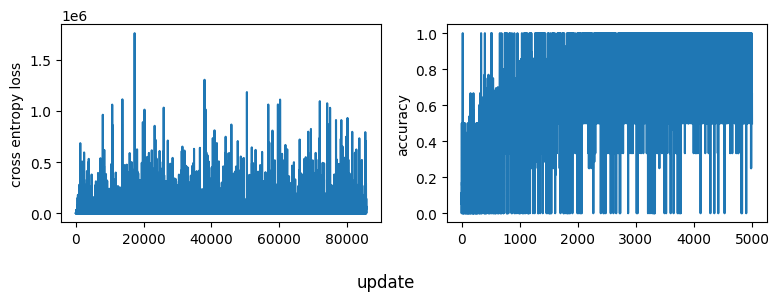

In [78]:
fig = pt.figure(figsize=(8,3))
pt.subplot(1,2,1)
pt.plot(loss_curve)
pt.ylabel("cross entropy loss")
pt.subplot(1,2,2)
pt.plot(accu_curve)
pt.ylabel("accuracy")
fig.supxlabel("update")
_ = pt.tight_layout()
